# Third Assignment Part 3: optimal product prediction using regression

In this colab, we develop the third line of work proposed for the project: to predict which will be the best product, based on the expected expense per person. 

To perform this prediction, we will make use of the datacard 3, which contains data from all the different products, for all the regions of Spain, between years 2018 and 2019.

The authors of the colab are:

<table>
  <thead>
    <th>Name</th>
    <th>Github</th>
    <th>E-Mail</th>
  </thead>
  <tbody>
    <tr>
      <td>Raúl Barba Rojas</td>
      <td><a href="https://github.com/RaulBarbaRojas">RaulBarbaRojas</a></td>
      <td><a href="mailto:Raul.Barba@alu.uclm.es">Raul.Barba@alu.uclm.es</a></td>
    </tr>
    <tr>
      <td>Diego Guerrero Del Pozo</td>
      <td><a href="https://github.com/DiegoGDP">DiegoGDP</a></td>
      <td><a href="mailto:Diego.Guerrero@alu.uclm.es">Diego.Guerrero@alu.uclm.es</a></td>
    </tr>
    <tr>
      <td>Maja Anna Swierk</td>
      <td><a href="https://github.com/manna8">Manna8</a></td>
      <td><a href="mailto:MajaAnna.Swierk@alu.uclm.es">MajaAnna.Swierk@alu.uclm.es</a></td>
    </tr>
    <tr>
      <td>Jakub Konieczny</td>
      <td><a href="https://github.com/KubaKonieczny">KubaKonieczny</a></td>
      <td><a href="mailto:Jakub.Konieczny@alu.uclm.es">Jakub.Konieczny@alu.uclm.es</a></td>
    </tr>
  </tbody>
</table>

# 1. Strategy to solve the problem

In order to solve the problem, we first need to decide which algorithm/s should be used to solve the problem.

First of all, we have a regression problem, thus we have to apply algorithms that are able to perform regression. In this case, let us consider multiple algorithms to decide which of them fits better:

- KNN (neighbor regression): this algorithm could be good for several reasons: we do not need a fast test stage (the prediction is not critical in terms of time), it can provide an adaptive behaviour... However, there is something that made us not choose this algorithm: it requires a sample that is large enough to solve the problem. In our case, although we have a lot of data, we dont have data from too many years (only 2), thus we consider that this algorithm would give a prediction not quite as accurate as other algorithms (also the model could overfit easily).

- Random forests: we opted to use this algorithm as one possible algorithm for solving the problem. The main reasons are that overfitting is not a problem in this algorithm (you have multiple decision trees), and also, because as it is an ensemble model, we consider that the prediction could have a higher accuracy than other algorithms (such as a simple decision tree). There is one really important consideration: random forest regression cannot be performed outside of the range used for training. However, we have to consider something: since the year was proven to be a worthless variable, all the predictions will be inside the range used for training, thus the model can be applied to this case study.

- GradientBoosting: it is another possible algorithm for solving our problem. Unlike the random forest, it is capable of performing regression outside of the range used for training, while still providing satisfactory results. Taking it into consideration, we will use this algorithm for regression.

- SVM: we wanted to use this algorithm for regression (SVR), because it is widely known algorithm and, in the contrary to Random Forest and GradientBoosting, it does not base on ensembly. However, learning took too much time and didn't give good results, so we've decided to abandon developing this algorithm.

- Neural networks: this option produces models able to provide the best results, specially if developed with a proper parametrization, like a good number of epochs to prevent overfitting. However, we do not implement this in our final solution since it was developed after using GradientBoosting.

# 2. Preparing the google colab environment

This google colab requires the data file related to the datacard 3. 

For that reason, a file called `datacard_h3_not_normalized.txt` obtained from the [assignment 2 part 3 colab](https://colab.research.google.com/drive/1JfrM3z9dFb2kRn9BI9SfrOA7WsNf2_kL) must be uploaded in the /content/ directory.

Once that has been done, we can load the datacard 3:

In [ ]:
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd

datacard3 = pd.read_csv('/content/datacard_h3_not_normalized.txt')
datacard3.drop(columns = ['Unnamed: 0'], inplace = True)
datacard3.fillna(0)
datacard3[datacard3.isnull().any(axis=1)]

,year,month,CCAA,Producto,GASTO X CAPITA,PENETRACION (%),PRECIO MEDIO kg ó litros


# 3. Generating training and test datasets

We have to divide our dataset into two different parts: training and test. 

We decided to split it according to the following proportion: 80% training, 20% testing, because those are the normal proportions in order to train and test the machine learning models. Let us perform the division:

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

encoder_regions = LabelEncoder()
encoder_regions.fit(datacard3['CCAA'])
datacard3['CCAA'] = encoder_regions.transform(datacard3['CCAA'])

encoder_products = LabelEncoder()
encoder_products.fit(datacard3['Producto'])
datacard3['Producto'] = encoder_products.transform(datacard3['Producto'])

datacard3.reset_index(inplace = True)
datacard3.drop(columns = ['index', 'year'], errors = 'ignore', inplace = True)
x_train, x_test, y_train, y_test = train_test_split(datacard3[['month', 'CCAA', 'Producto', 'PENETRACION (%)', 'PRECIO MEDIO kg ó litros']], datacard3[['GASTO X CAPITA']], test_size=0.2, random_state = 0)

As a result of the previous code, we obtained the following variables:

`x_train`: a variable that contains the training data (without the predicted value).

`x_test`: a variable that contains the testing data (without the predicted value).

`y_train`: a variable that contains the training values for each training record.

`y_test`: a variable that contains the testing values for each testing record.


# 4. Regression with random forests

In this section we will apply random forests in order to perform the regression to obtain the model for predicting values.

There is one really important consideration: random forest regression cannot be performed outside of the range used for training. However, we have to consider something: since the year was proven to be a worthless variable, all the predictions will be inside the range used for training, thus the model can be applied to this case study.

## 4.1. Parametrization and model creation

In order to have the best possible results, we have to select the optimal hyperparameters for our problem. There are multiple options in order to perform hyperparametrization: random search, grid search, bayes search...

In this case, we decided to use bayes search. The reason behind the decision is that it is quite fast to implement, and usually provides good results with fairly few iterations.

Several values for the two parameters (number of estimators and maximum depth) have been tried, but, due to time limitations, only the best ones are show below. If there were any more, the time needed to run the code would be in the order of days.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

params = {
    "n_estimators": [512, 1024],
    "max_depth": [4, 5],
}

RFregressor = RandomForestRegressor(criterion = 'absolute_error', n_jobs = -1, random_state = 0)
grid_search_models = GridSearchCV(estimator = RFregressor, cv = 5, refit = True, param_grid = params, verbose = 2)
grid_search_models.fit(x_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=4, n_estimators=512; total time= 4.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=4, n_estimators=512; total time= 4.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=4, n_estimators=512; total time= 4.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=4, n_estimators=512; total time= 4.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=4, n_estimators=512; total time= 4.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=4, n_estimators=1024; total time= 8.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=4, n_estimators=1024; total time= 8.5min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=4, n_estimators=1024; total time= 8.6min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=4, n_estimators=1024; total time= 8.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=4, n_estimators=1024; total time= 8.5min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=5, n_estimators=512; total time= 4.5min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=5, n_estimators=512; total time= 4.5min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=5, n_estimators=512; total time= 4.6min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=5, n_estimators=512; total time= 4.6min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=5, n_estimators=512; total time= 4.6min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=5, n_estimators=1024; total time= 9.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=5, n_estimators=1024; total time= 9.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=5, n_estimators=1024; total time= 9.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=5, n_estimators=1024; total time= 9.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=5, n_estimators=1024; total time= 9.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5,
             estimator=RandomForestRegressor(criterion='absolute_error',
                                             n_jobs=-1, random_state=0),
             param_grid={'max_depth': [4, 5], 'n_estimators': [512, 1024]},
             verbose=2)

Below, we show the score of the best model as well as its parameters:

In [ ]:
print("Best score:", str(grid_search_models.best_score_))
print("Best parameters:", str(grid_search_models.best_params_))

Best score: 0.7830742790611387
Best parameters: {'max_depth': 5, 'n_estimators': 512}


## 4.2. Results evaluation

Now let us launch the optimization study. In this case, the idea is to minimize the error (or maximize the score):

### 4.2.1. MAE

First, we can try with MAE:

In [ ]:
mae = mean_absolute_error(y_test, grid_search_models.predict(x_test))
print("Error with MAE:",  mae)

Error with MAE: 0.1403497799536026


### 4.2.2. MSE

After trying with MAE, we can use MSE:

In [ ]:
mse = mean_squared_error(y_test, grid_search_models.predict(x_test))
print("Error with MSE:",  mse)

Error with MSE: 0.07029873935935456


### 4.2.3. R2 Score


We can also import the R2 score to test it:

In [ ]:
r2 = r2_score(y_test, grid_search_models.predict(x_test))
print("Error with R2 score:",  r2)

Error with R2 score: 0.7664677640430302


### 4.2.4. RMSE

Finally, we can use RMSE:

In [ ]:
rmse = mean_squared_error(y_test, grid_search_models.predict(x_test), squared=False)
print("Error with RMSE:",  rmse)

Error with RMSE: 0.2651390943624771


## 4.3. Saving the model

We are can save the best Random Forest model as joblib file named: `random_forest_model.joblib`

In [ ]:
import joblib
joblib.dump(grid_search_models, 'random_forest_model.joblib')

['random_forest_model.joblib']

# 5. Regression with GradientBoosting

In this section we will apply Gradient Boosting in order to perform the regression to obtain the model for predicting values.
\
Gradient Boosting, in contrary to Random Forest, is able to predict outside of the range used for training.


## 5.1. Parametrization


In the first attempt of chosing parameters we set max_depth up to 10, being 10 the chosen value, but overfitting occured. Because of this, we decided to check the depth only in range between 1 and 5.

In [ ]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 4.3 MB/s eta 0:00:00


We set the parameters to be tried during the parametrization:

In [ ]:
import random
params = {
    "n_estimators": [10, 50, 100, 200, 300, 500, 1000],
    "max_depth": [1,2, 3, 4, 5],
    "min_samples_split": [2, 5, 10, 20],
    "learning_rate": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100] ,
    "loss": ["squared_error", "absolute_error", "huber"]
}

And we build and fit the model:

In [ ]:
from sklearn import ensemble
from skopt import BayesSearchCV
from sklearn.model_selection import RandomizedSearchCV

search = RandomizedSearchCV(estimator=ensemble.GradientBoostingRegressor(), param_distributions=params, n_jobs=-1, cv=5, n_iter=100, verbose=3)
search.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [ 6.68271120e-002  1.41200691e-001  5.00054570e-001             -inf
             -inf              nan  8.90191322e-001 -5.85501472e-002
  8.56397150e-001 -4.29123018e+039 -6.20437377e+190 -2.01337386e+095
             -inf  8.51112420e-001 -6.06680073e+190  2.47453792e-001
  3.52709413e-001  8.28750106e-001  4.06100844e-002  8.75814187e-001
  2.35966450e-002  8.95533177e-001  7.70840766e-001  8.31430324e-001
  8.64230241e-001 -6.35382247e+039              nan  8.60398394e-001
  8.45566207e-001  8.52468893e-001              nan             -inf
  6.02130134e-001  8.54493188e-001              nan              nan
  8.69419166e-001  8.97242726e-001             -inf  5.84895858e-001
 -1.31564884e-001  8.57757479e-001  2.56834882e-001 -3.07521505e-002
 -7.88616011e-002  8.63896338e-001              nan  6.03362979e-002
  8.38122885e-001 -1.37187140e-00

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [1e-05, 0.0001, 0.001,
                                                          0.01, 0.1, 1, 10,
                                                          100],
                                        'loss': ['squared_error',
                                                 'absolute_error', 'huber'],
                                        'max_depth': [1, 2, 3, 4, 5],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'n_estimators': [10, 50, 100, 200, 300,
                                                         500, 1000]},
                   verbose=3)

Finally, we print the results obtained:

In [ ]:
print("Best score:", str(search.best_score_))
print("Best parameters:", str(search.best_params_))

Best score: 0.8965865716043615
Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 5, 'loss': 'squared_error', 'learning_rate': 0.1}


## 5.2. Model creation


In this section we will build the model with the Gradient Boosting Regressor:

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

GBreg = ensemble.GradientBoostingRegressor(**search.best_params_)
GBreg.fit(x_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(max_depth=5, n_estimators=200)

With the previously mentioned best parameters:

In [ ]:
search.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'max_depth': 5,
 'loss': 'squared_error',
 'learning_rate': 0.1}

## 5.3. Results evaluation

Now again, we can evaluate the model with the different metrics:

### 5.3.1. MAE

With MAE:

In [ ]:
mae = mean_absolute_error(y_test, GBreg.predict(x_test))
print("Error measure with MAE:",  mae)

Error measure with MAE: 0.0920249358054619


As we can see this time there is no overfiting at all, or it occurs, but it is very small. Even though results on the test set are worse than in previous approach (0.10 vs 0.09), we decided to keep this version because it generalizes in better way.

### 5.3.2. MSE

With MSE:

In [ ]:
mse = mean_squared_error(y_test, GBreg.predict(x_test))
print("Error measure with MSE:",  mse)

Error measure with MSE: 0.031547018862115486


### 5.3.3. R2 Score

With R2 score:

In [ ]:
r2 = r2_score(y_test, GBreg.predict(x_test))
print("Error measure with R2 score:",  r2)

Error measure with R2 score: 0.8952008824086234


### 5.3.4. RMSE

With RMSE:

In [ ]:
rmse = mean_squared_error(y_test, GBreg.predict(x_test), squared = False)
print("Error measure with RMSE:",  rmse)

Error measure with RMSE: 0.1776148047379933


## 5.4. Saving the model

We are saving the best Gradient Boosting model as joblib file named: `gradient_boosting_model.joblib`

In [ ]:
import joblib
joblib.dump(GBreg, 'gradient_boosting_model.joblib')

['gradient_boosting_model.joblib']

# 6. Regression with SVM

As third method of regression we wanted to use the SVM, but learning took long time and it did not give satisfactory results. Due to that we decided to stop working on that algorithm.

## 6.1. Parametrization

First, we import the necessary libraries:

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

We will use three different kernels to try SVM:

In [ ]:
svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svr_lin = SVR(kernel="linear", C=100, gamma="auto")
svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)

And we define a series of parameters to try:

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import RepeatedStratifiedKFold

params= {
        'C': Real(1e-6, 1e+6, prior='log-uniform'),
        'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
        'degree': Integer(1,8),
        'kernel': Categorical(['linear', 'poly', 'rbf']),
}

# Define evaluation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)

# Define the search
search = BayesSearchCV(estimator=SVR(), search_spaces=params, n_jobs=-1, cv=5, n_iter=15, verbose = True)

Finally, we can measure the score of the best one, as well as see its parameters:

In [ ]:
from google.colab import output

search.fit(x_train, y_train)
output.clear()

# Report the best result
print(search.best_score_)
print(search.best_params_)

0.7797729596686558
OrderedDict([('C', 1000000.0), ('degree', 7), ('gamma', 0.14554907133660852), ('kernel', 'rbf')])


## 6.2. Model creation

We are creating the model with the best parameters from  Bayes search:

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
 
SVregressor = SVR(C = search.best_params_.get('C'), degree = search.best_params_.get('degree'),
                  gamma = search.best_params_.get('gamma'), kernel = search.best_params_.get('kernel'))
SVregressor.fit(x_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1000000.0, degree=7, gamma=0.14554907133660852)

## 6.3. Results evaluation

Now, we can measure the results of the evaluation:

### 6.3.1. MAE

With MAE:

In [ ]:
mae = mean_absolute_error(y_test, SVregressor.predict(x_test))
print("Error measure with MAE:", mae)

Error measure with MAE: 0.16422348447229365


### 6.3.2. MSE

With MSE:

In [ ]:
mse = mean_squared_error(y_test, SVregressor.predict(x_test))
print("Error measure with MSE:", mse)

Error measure with MSE: 0.0665785512199411


### 6.3.3. R2 Score

With R2 score:

In [ ]:
r2 = r2_score(y_test, SVregressor.predict(x_test))
print("Error measure with R2 score:", r2)

Error measure with R2 score: 0.7788262197179856


### 6.3.4. RMSE

With RMSE:

In [ ]:
rmse = mean_squared_error(y_test, SVregressor.predict(x_test), squared=False)
print("Error measure with RMSE:", rmse)

Error measure with RMSE: 0.25802819849764697


## 6.4. Saving the model

We are saving the best Support Vector Regression model as joblib file named: `SVR_model.joblib`

In [ ]:
import joblib
joblib.dump(SVregressor, 'SVR_model.joblib')

['SVR_model.joblib']

# 7. Regression with Neural Networks

Finally, we can try using neural networks for our regression purposes. Sadly, we have already implemented GradientBoosting in our solution, but it is always interesting to see the results of using this approach.

## 7.1. Model creation

In this case, we will using some arbitrary values for our neural networks, which implements a dense layer of 20 nodes with a `relu` activation function, and another dense layer with only 1 node for the output value. A better parametrization could led to potentially improved results.

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from keras.regularizers import l1
import matplotlib.pyplot as plt

# Commonly used modules
import numpy as np

train = x_train.join(y_train)

NNmodel = keras.Sequential([
        Dense(20, activation=tf.nn.relu, input_shape=[len(train.columns)],  activity_regularizer=l1(0.001)),
        Dense(1)
    ])

NNmodel.compile(optimizer="adam", 
                  loss='mse',
                  metrics=['mae', 'mse'])

Now that we implemented our model, we can start training for 20 epochs, a value chosen to prevent overfitting, since training for longer times makes the model suffer from this phenom at around 30-40 epochs.

In [ ]:
history = NNmodel.fit(train, train['GASTO X CAPITA'], epochs = 20, verbose = 1, validation_split = 0.2)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

rmse_final = np.sqrt(float(hist['val_mse'].tail(1)))
print('\nRMSE for validation: {}'.format(round(rmse_final, 3)))

Epoch 1/20
344/344 [==============================] - 1s 2ms/step - loss: 0.0928 - mae: 0.0503 - mse: 0.0052 - val_loss: 0.0903 - val_mae: 0.0497 - val_mse: 0.0052
Epoch 2/20
344/344 [==============================] - 1s 2ms/step - loss: 0.0873 - mae: 0.0454 - mse: 0.0042 - val_loss: 0.0854 - val_mae: 0.0541 - val_mse: 0.0051
Epoch 3/20
344/344 [==============================] - 1s 3ms/step - loss: 0.0815 - mae: 0.0424 - mse: 0.0037 - val_loss: 0.0789 - val_mae: 0.0411 - val_mse: 0.0039
Epoch 4/20
344/344 [==============================] - 1s 3ms/step - loss: 0.0754 - mae: 0.0372 - mse: 0.0031 - val_loss: 0.0723 - val_mae: 0.0352 - val_mse: 0.0030
Epoch 5/20
344/344 [==============================] - 1s 3ms/step - loss: 0.0697 - mae: 0.0379 - mse: 0.0033 - val_loss: 0.0666 - val_mae: 0.0384 - val_mse: 0.0033
Epoch 6/20
344/344 [==============================] - 1s 2ms/step - loss: 0.0639 - mae: 0.0402 - mse: 0.0036 - val_loss: 0.0607 - val_mae: 0.0378 - val_mse: 0.0035
Epoch 7/20
344/3

## 7.2. Results evaluation

As always, it is interesting to evaluate the results obtained from the training:

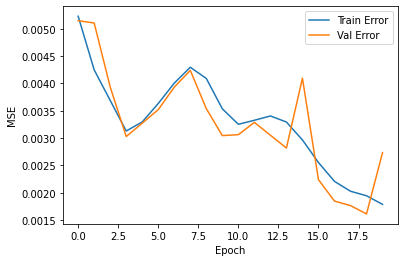

In [ ]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.legend()
    

plot_history()

As we can see, the validation loss seems to be consistently decreasing, which indicates that no overfitting is present, as we previously stated. We can see the RMSE loss in this case:

In [ ]:
test = x_test.join(y_test)
mse, _, _ = NNmodel.evaluate(test, test['GASTO X CAPITA'])
rmse = np.sqrt(mse)
print('RMSE for test: {}'.format(round(rmse, 3)))

108/108 [==============================] - 0s 1ms/step - loss: 0.0092 - mae: 0.0380 - mse: 0.0027
RMSE for test: 0.096


It is very low, making this model the best one achieved at this point. With the following graphic we can see how good our model is at predicting:

4/4 [==============================] - 0s 4ms/step


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


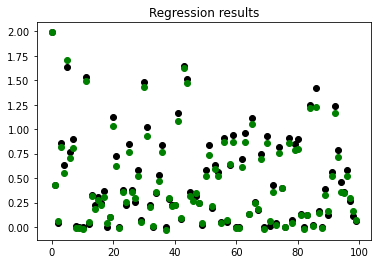

In [ ]:
y_pred = NNmodel.predict(test.head(100))

xx = np.stack(i for i in range(len(test['GASTO X CAPITA'].head(100))))  
plt.scatter(xx, test['GASTO X CAPITA'].head(100), c='k', label='Data')
plt.scatter(xx, y_pred, c='g', label='Prediction')
plt.title("Regression results" )

plt.show()

With the green points representing the predicted values and the black ones representing the real values, we can see how our model predicts very close values to the real ones.

## 7.3. Saving the model

Finally, we can save the model:

In [ ]:
import joblib
joblib.dump(NNmodel, 'Neural_Network_model.joblib')

['Neural_Network_model.joblib']

# 8. Optimal product prediction

Once we have implemented all the models and measured all the necessary stats about them, we can check the following comparative table:

|                   |   MAE  |   MSE  | R2 Score |  RMSE  |
|-------------------|:------:|:------:|:--------:|:------:|
|     Random Forest | 0.1403 | 0.0703 |  0.7665  | 0.2651 |
| Gradient Boosting | 0.0920 | 0.0315 |  0.8952  | 0.1776 |
|               SVM | 0.1642 | 0.0665 |  0.7788  | 0.2580 |
|    Neural Network | 0.0386 | 0.0090 |     -    | 0.0960 |

The conclusions that can be obtained from these results are quite clear: the neural network is the best model even without a proper parametrization, while the best one out of the first three is the GradientBoosting, implemented in our solution, since, as we mentioned before we developed our neural network later on.

The implementation of the system can be found in this [repository](https://github.com/RaulBarbaRojas/DataMining).

This implementation consists in an API based on Postman, working through post requests, and implementing 4 different services:

- OptimalProduct: given a month and a year, returns the optimal product to sell in that moment.
- OptimalProductCCAA: the same as the previous one, but also given an specific region.
- SpecificProduct: given a month, a year and a product, returns the expected value at that moment.
- SpecificProductCCAA: the same as the previous one, but in a given region.